# Image Preprocessing for Sheep Detection

In [67]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Load Image and Convert to Grayscale

In [74]:
example_images = [
    'DJI_20240125160526_0002_T.JPG',
    'DJI_20240125160538_0008_T.JPG', 
    'DJI_20240125160618_0028_T.JPG', 
    'DJI_20240125160820_0089_T.JPG',
    'DJI_20240125160808_0083_T.JPG'
]

def plot_images(images: list):
    fig, axes = plt.subplots(1, len(images), figsize=(5 * len(images), 5))

    if len(images) == 1:
        axes = [axes]

    for ax, gray, idx in zip(axes, images, range(1, len(images)+1)):
        ax.imshow(gray, cmap='gray')
        ax.set_title(f'Gray {idx}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

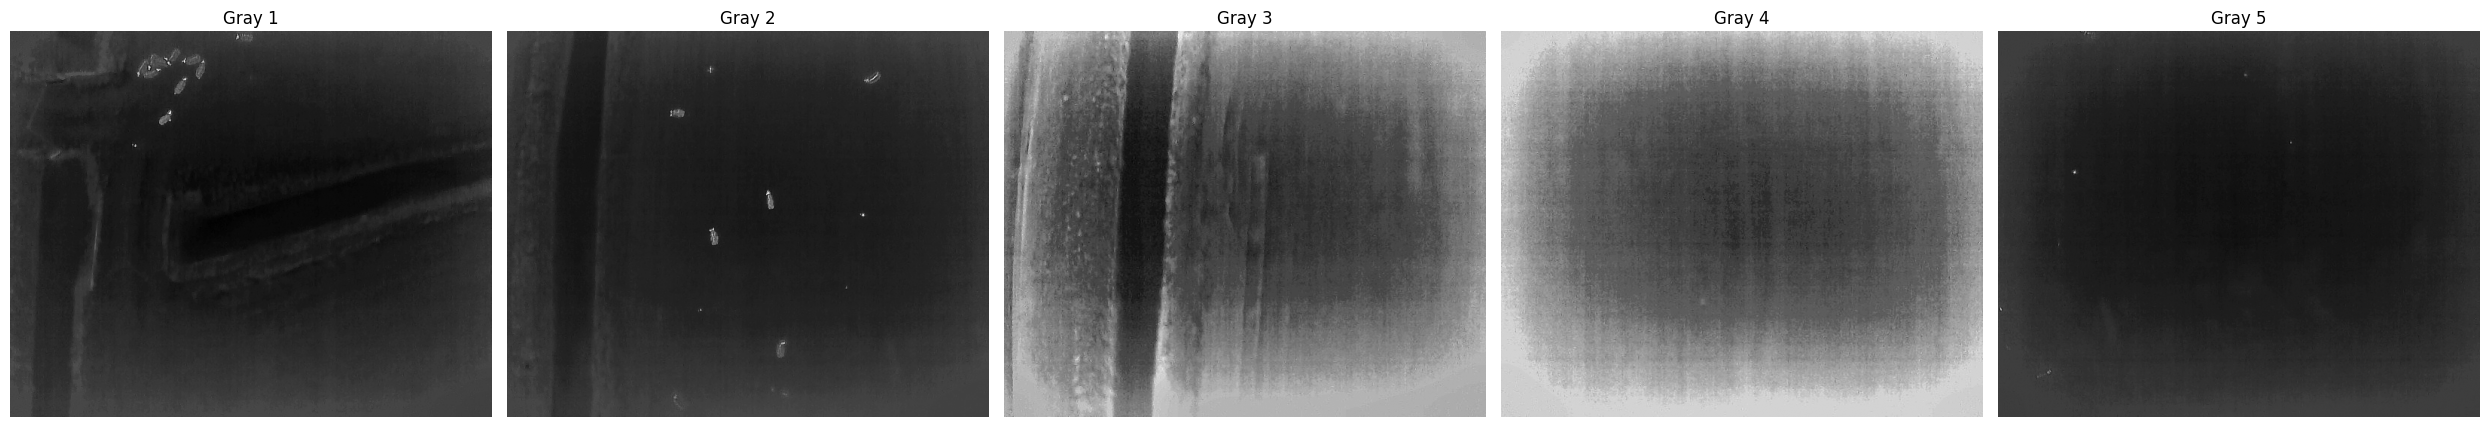

In [75]:
def load_image(path: str) -> np.ndarray:
    image = cv2.imread(path)
    if image is None:
        raise ValueError(f"Failed to load image at path: {path}")
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray_images = [load_image(f'../dataset/images/{img_name}') for img_name in example_images]

plot_images(gray_images)

### Vignette Correction

The orinal image are more clear in the center than the outside, this likely caused by the camera lens. This is called a vignette.
To remove uneven lighting or dark corners (vignetting), we blur the image to estimate the background and subtract it from the original.

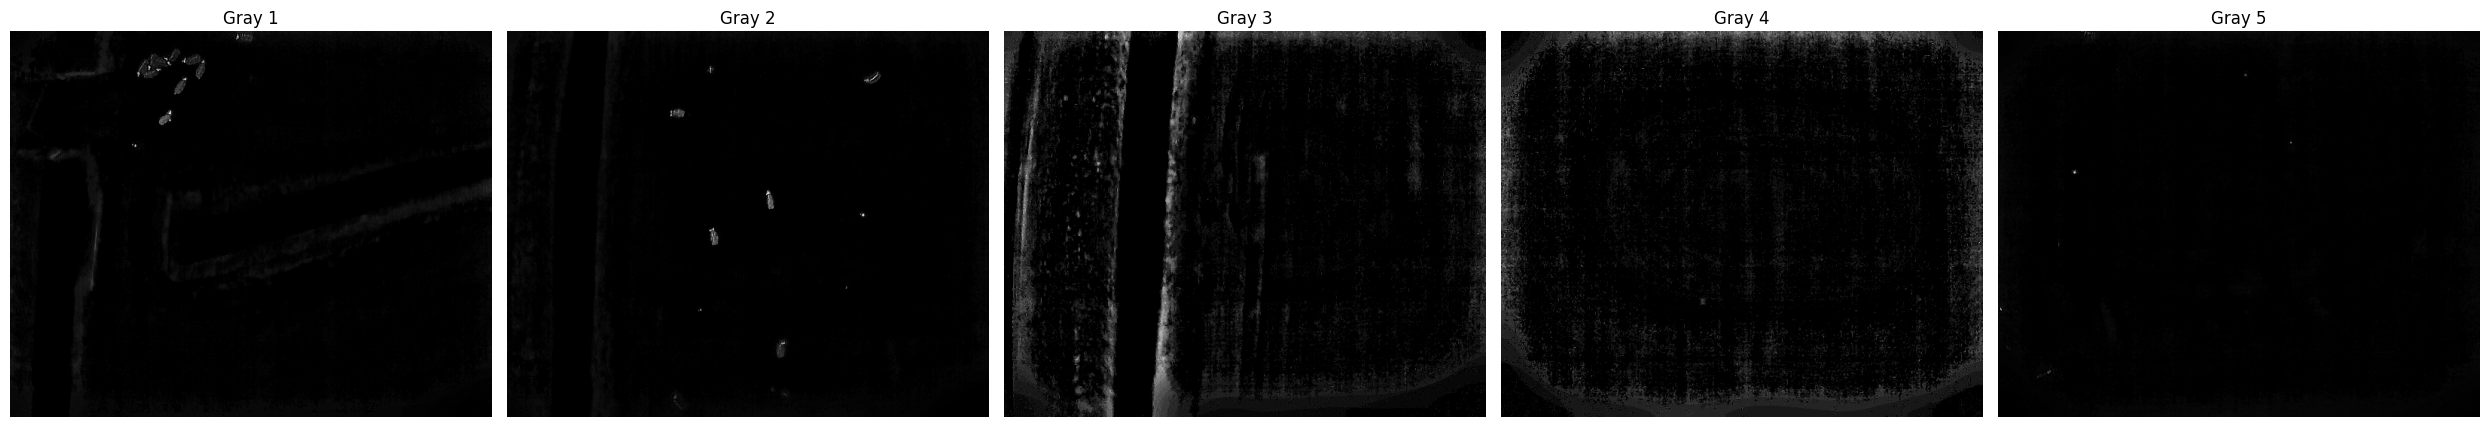

In [76]:
def remove_vignette(img: np.ndarray) -> np.ndarray:
    background = cv2.GaussianBlur(img, (201, 201), 0)
    corrected = cv2.subtract(img, background)
    return cv2.normalize(corrected, None, 0, 255, cv2.NORM_MINMAX)


corrected_images = [remove_vignette(img) for img in gray_images]

plot_images(corrected_images)

As you can see the images are now mutch more clear.

### Denoising

The image can still have some noise this can be caused my removing the vignette so first we need to do a correction.

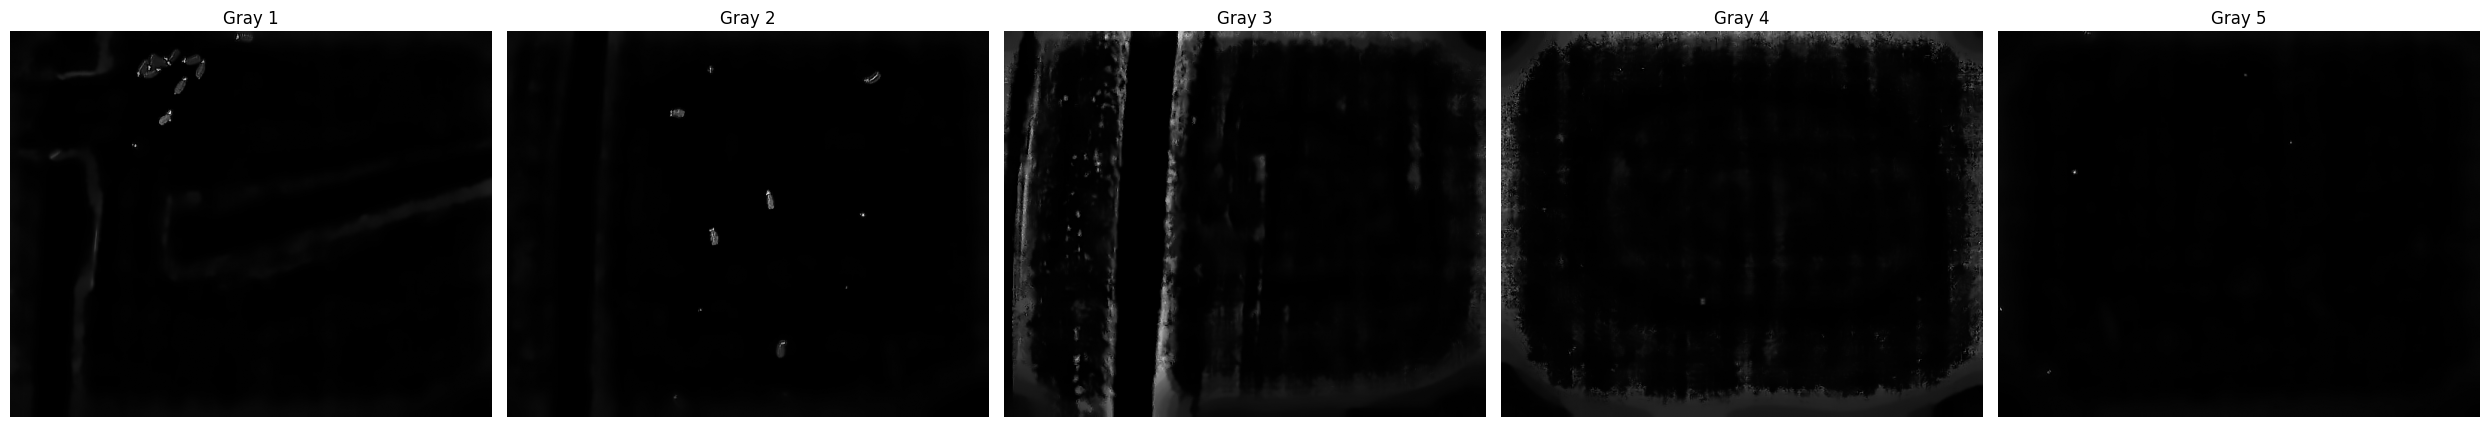

In [77]:
def remove_noise(img: np.ndarray) -> np.ndarray:
    return cv2.fastNlMeansDenoising(img, h=10)

denoised_images = [remove_noise(img) for img in corrected_images]

plot_images(denoised_images)

### CLAHE (Contrast Limited Adaptive Histogram Equalization)
To boost local contrast and make subtle features (like small sheep blobs) more visible without overexposing the image.

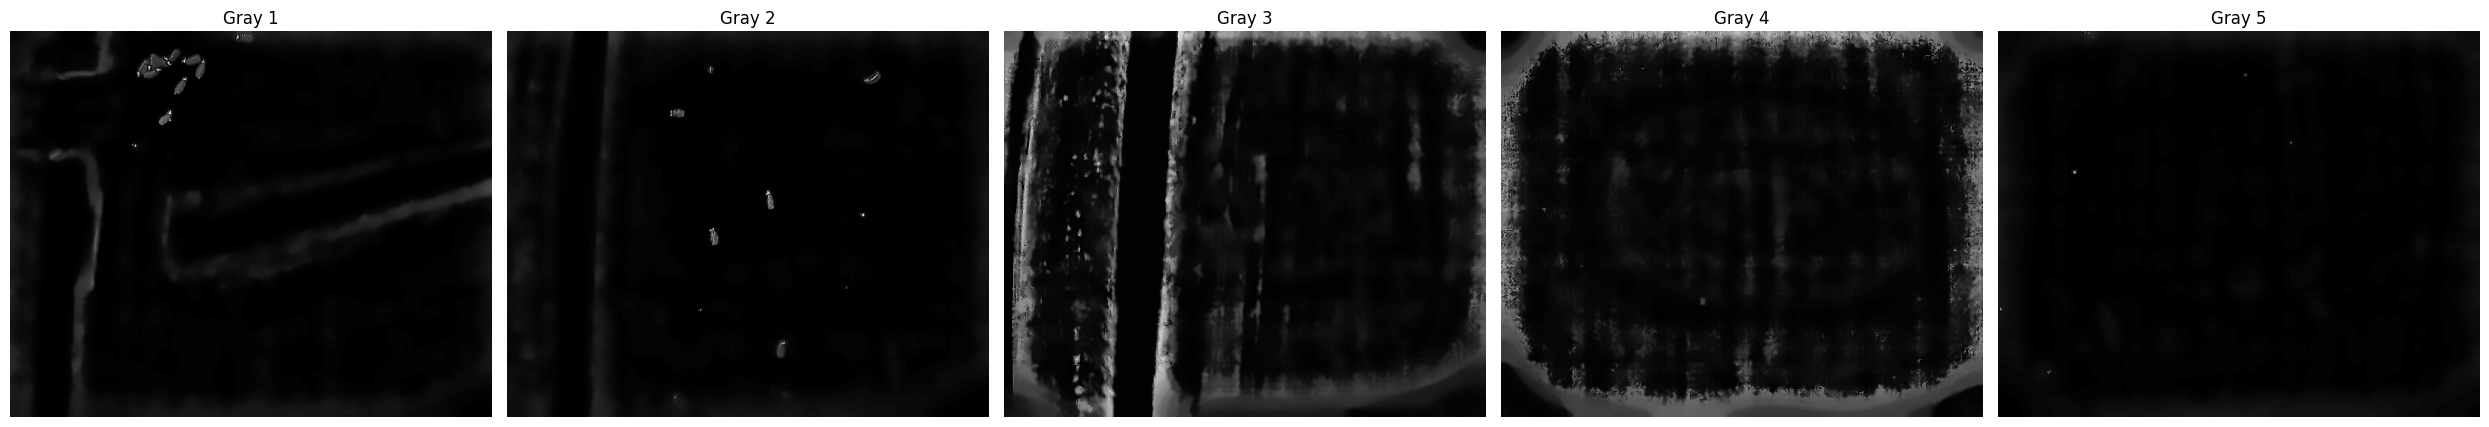

In [78]:
def apply_clahe(img: np.ndarray) -> np.ndarray:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)


enhanced_images = [apply_clahe(img) for img in denoised_images]

plot_images(enhanced_images)

Now we can apply this for every image.

In [73]:
import os

images = os.listdir('../dataset/images')

def enhance_image(img: str):
    image = load_image(img)
    image = remove_vignette(image)
    image = remove_noise(image)
    return apply_clahe(image)
    


output_dir = '../dataset/images/enhanced/'
os.makedirs(output_dir, exist_ok=True)

for image_name in images:
    input_path = f'../dataset/images/{image_name}'
    output_path = f'{output_dir}{image_name}'
    
    image = enhance_image(input_path)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.imwrite(output_path, image)
